In [43]:
import numpy as np 
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# Load data and Prepare

In [44]:
heat = pd.read_csv('../02-data/case-demand-prediction-nytt-data.csv')
df = heat.copy()

Parse date 

In [45]:
df['tstamp'] = pd.to_datetime(df['tstamp'], format='%d/%m/%Y %H:%M') #01/01/2012 00:00
df = df.set_index('tstamp').sort_index()

df.head()

,consumed_heat,temp,cloud,day_of_week,holiday_in_general,school_holiday_period,public_holiday_period,wind_direction,wind_speed
tstamp,,,,,,,,,
2012-01-01 00:00:00,21.441080,-8.8,13.0,Sunday,1.0,1.0,1.0,0.0,0.0
2012-01-01 01:00:00,21.636080,-8.5,13.0,Sunday,1.0,1.0,1.0,0.0,0.0
2012-01-01 02:00:00,21.195580,-8.8,13.0,Sunday,1.0,1.0,1.0,130.0,1.0
2012-01-01 03:00:00,20.775913,-8.2,13.0,Sunday,1.0,1.0,1.0,130.0,1.0
2012-01-01 04:00:00,20.453913,-6.7,13.0,Sunday,1.0,1.0,1.0,110.0,1.0


In [46]:
df.isnull().sum()

consumed_heat              0
temp                     285
cloud                    285
day_of_week              285
holiday_in_general       285
school_holiday_period    285
public_holiday_period    285
wind_direction           351
wind_speed               351
dtype: int64

In [47]:
columns_with_nans = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()
print(columns_with_nans)
df = df.dropna(subset=columns_with_nans)

['temp', 'cloud', 'day_of_week', 'holiday_in_general', 'school_holiday_period', 'public_holiday_period', 'wind_direction', 'wind_speed']


In [48]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

# Feature engineering

### Lag features (previous hour and previous day at the same time)
This is not entirely correct as I removed ~300 rows earlier. But given the fast that there are still 64634 rows, this effect is negligible.

In [49]:
#df['lag_1'] = df['consumed_heat'].shift(1)
df['lag_24'] = df['consumed_heat'].shift(24)
df.head(3)

,consumed_heat,temp,cloud,day_of_week,holiday_in_general,school_holiday_period,public_holiday_period,wind_direction,wind_speed,lag_24
tstamp,,,,,,,,,,
2012-01-01 00:00:00,21.44108,-8.8,13.0,Sunday,1.0,1.0,1.0,0.0,0.0,NaN
2012-01-01 01:00:00,21.63608,-8.5,13.0,Sunday,1.0,1.0,1.0,0.0,0.0,NaN
2012-01-01 02:00:00,21.19558,-8.8,13.0,Sunday,1.0,1.0,1.0,130.0,1.0,NaN


### Create columns with hour, day, month, year
I think year doesn't make a difference. But I'll try this anyways.

In [50]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)


In [51]:
df.head()

,consumed_heat,temp,cloud,day_of_week,holiday_in_general,school_holiday_period,public_holiday_period,wind_direction,wind_speed,lag_24,hour,day,month,year,is_weekend
tstamp,,,,,,,,,,,,,,,
2012-01-01 00:00:00,21.441080,-8.8,13.0,Sunday,1.0,1.0,1.0,0.0,0.0,NaN,0,1,1,2012,1
2012-01-01 01:00:00,21.636080,-8.5,13.0,Sunday,1.0,1.0,1.0,0.0,0.0,NaN,1,1,1,2012,1
2012-01-01 02:00:00,21.195580,-8.8,13.0,Sunday,1.0,1.0,1.0,130.0,1.0,NaN,2,1,1,2012,1
2012-01-01 03:00:00,20.775913,-8.2,13.0,Sunday,1.0,1.0,1.0,130.0,1.0,NaN,3,1,1,2012,1
2012-01-01 04:00:00,20.453913,-6.7,13.0,Sunday,1.0,1.0,1.0,110.0,1.0,NaN,4,1,1,2012,1


## Enccode categorical variables

In [52]:
df.day_of_week.unique()

array(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday'], dtype=object)

In [53]:
numerical_cols = df.select_dtypes(include='number').columns.tolist()
other_cols = df.select_dtypes(include=object).columns.tolist()

print("Numerical: ", numerical_cols)
print("Other: ", other_cols)

Numerical:  ['consumed_heat', 'temp', 'cloud', 'holiday_in_general', 'school_holiday_period', 'public_holiday_period', 'wind_direction', 'wind_speed', 'lag_24', 'hour', 'day', 'month', 'year', 'is_weekend']
Other:  ['day_of_week']


`drop_first=True` removes one of the newly created dummy variable columns for each original categorical feature. This is done to prevent a statistical issue called multicollinearity.
By using drop_first=True, you provide all the necessary information to the model without introducing redundant data, which is a standard best practice for feature engineering.
When you use pd.get_dummies to convert a categorical column (like 'day_of_week' or 'weather_type'), it creates a new binary (0 or 1) column for each unique category. This process is called one-hot encoding.

The problem is that these new columns are perfectly correlated. The value of one column can be perfectly predicted from the values of the others. For many machine learning models (especially linear models like Linear Regression), this multicollinearity can cause problems with model training and interpretability.

By setting drop_first=True, you drop one category, which becomes the "baseline" or "reference" category. The model can infer the presence of this dropped category when all other dummy columns for that feature are 0.

In [54]:
# one-hot encoding
df = pd.get_dummies(df, columns=other_cols, drop_first=True)

In [55]:
df.shape

(64634, 20)

# Now remove new NaNs created from lag features

In [56]:
cols = ['lag_24']
df[cols].isnull().sum()

lag_24    24
dtype: int64

In [57]:
df = df.dropna(axis=0, subset=cols)
df.isnull().sum()

consumed_heat            0
temp                     0
cloud                    0
holiday_in_general       0
school_holiday_period    0
public_holiday_period    0
wind_direction           0
wind_speed               0
lag_24                   0
hour                     0
day                      0
month                    0
year                     0
is_weekend               0
day_of_week_Monday       0
day_of_week_Saturday     0
day_of_week_Sunday       0
day_of_week_Thursday     0
day_of_week_Tuesday      0
day_of_week_Wednesday    0
dtype: int64

In [58]:
#df.to_csv("../02-data/data_cleaned_engineered.csv")

In [59]:
df.head()

,consumed_heat,temp,cloud,holiday_in_general,school_holiday_period,public_holiday_period,wind_direction,wind_speed,lag_24,hour,day,month,year,is_weekend,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
tstamp,,,,,,,,,,,,,,,,,,,,
2012-01-02 00:00:00,16.373093,3.1,100.0,1.0,1.0,0.0,130.0,3.0,21.441080,0,2,1,2012,0,True,False,False,False,False,False
2012-01-02 01:00:00,15.306093,3.4,100.0,1.0,1.0,0.0,170.0,3.0,21.636080,1,2,1,2012,0,True,False,False,False,False,False
2012-01-02 02:00:00,14.863093,3.9,100.0,1.0,1.0,0.0,160.0,3.0,21.195580,2,2,1,2012,0,True,False,False,False,False,False
2012-01-02 03:00:00,14.246093,3.9,100.0,1.0,1.0,0.0,140.0,2.0,20.775913,3,2,1,2012,0,True,False,False,False,False,False
2012-01-02 04:00:00,14.297093,4.3,100.0,1.0,1.0,0.0,150.0,4.0,20.453913,4,2,1,2012,0,True,False,False,False,False,False


# Other things to do

Other features to engineer:
- lag of temperature
- rolling avg of the previous 24 hr
- temp_diff = change in temperature
- Interaction between temp and hour
- Create binary “holiday_effect” feature to collect all the columns

In [64]:
numeric_only.columns


Index(['consumed_heat', 'temp', 'cloud', 'holiday_in_general',
       'school_holiday_period', 'public_holiday_period', 'wind_direction',
       'wind_speed', 'lag_24', 'hour', 'day', 'month', 'year', 'is_weekend'],
      dtype='object')

<Axes: >

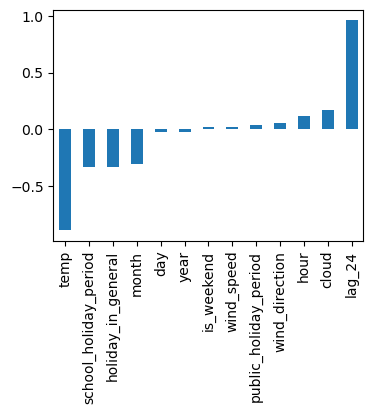

In [73]:
cols_corr = ['consumed_heat', 'temp', 'cloud', 'holiday_in_general',
       'school_holiday_period', 'public_holiday_period', 'wind_direction',
       'wind_speed', 'lag_24', 'hour', 'day', 'month', 'year', 'is_weekend']
#df.corr(cols_corr)['consumed_heat'].plot(kind='bar', figsize=(4,3))
df[cols_corr].corr()['consumed_heat'].drop('consumed_heat').sort_values().plot(kind='bar', figsize=(4,3))


# Shift 24 hr temp and wind (assuming these are values not available for forecast)

In [ ]:
df2 = df.copy()

In [ ]:
df2['temp_24'] = df2.temp.shift(24)
df2['cloud_24'] = df2.cloud.shift(24)
df2['wind_speed_24'] = df2.wind_speed.shift(24)
df2['wind_direction_24'] = df2.wind_direction.shift(24)

In [ ]:
df2.isnull().sum()

consumed_heat             0
temp                      0
cloud                     0
holiday_in_general        0
school_holiday_period     0
public_holiday_period     0
wind_direction            0
wind_speed                0
lag_24                    0
hour                      0
day                       0
month                     0
year                      0
is_weekend                0
day_of_week_Monday        0
day_of_week_Saturday      0
day_of_week_Sunday        0
day_of_week_Thursday      0
day_of_week_Tuesday       0
day_of_week_Wednesday     0
temp_24                  24
cloud_24                 24
wind_speed_24            24
wind_direction_24        24
dtype: int64

In [ ]:
df2 = df2.dropna(axis=0)

In [ ]:
df2.isnull().sum()

consumed_heat            0
temp                     0
cloud                    0
holiday_in_general       0
school_holiday_period    0
public_holiday_period    0
wind_direction           0
wind_speed               0
lag_24                   0
hour                     0
day                      0
month                    0
year                     0
is_weekend               0
day_of_week_Monday       0
day_of_week_Saturday     0
day_of_week_Sunday       0
day_of_week_Thursday     0
day_of_week_Tuesday      0
day_of_week_Wednesday    0
temp_24                  0
cloud_24                 0
wind_speed_24            0
wind_direction_24        0
dtype: int64

In [ ]:
df.to_csv("../02-data/data_cleaned_engineered_24h.csv")